# Assignment A

1. Design a 3-layer feedforward neural network consisting of a hidden-layer of 10 neurons having logistic activation function and an output softmax layer. Assume a learning rate 𝛼 = 0.01 and decay parameter 𝛽 = 10−6. Use appropriate scaling of input features

In [11]:
import numpy as np
import os
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

Above code is to import all necessary package. The most important package is Theano for making neural network.

In [12]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-np.min(X, axis=0))

# load dataset
def load_data(data_path):
    input_txt = np.loadtxt('dataset/sat_train.txt',delimiter=' ')
    X, _Y = input_txt[:,:36], input_txt[:,-1].astype(int)
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    X = scale(X, X_min, X_max)

    _Y[_Y == 7] = 6
    Y = np.zeros((_Y.shape[0], 6))
    Y[np.arange(_Y.shape[0]), _Y-1] = 1

    return X, Y


These functions are for preprocessing such as loading dataset and scaling. The scale function map the input into range [0,1]

In [13]:
# create bias tensor
def init_bias(n = 1):
    return(theano.shared(np.zeros(n), theano.config.floatX))

# create weights tensor
def init_weights(n_in=1, n_out=1, logistic=True):
    W_values = np.asarray(
        np.random.uniform(
        low=-np.sqrt(6. / (n_in + n_out)),
        high=np.sqrt(6. / (n_in + n_out)),
        size=(n_in, n_out)),
        dtype=theano.config.floatX
        )
    if logistic == True:
        W_values *= 4
    return (theano.shared(value=W_values, name='W', borrow=True))

# update parameters
def sgd(cost, params, lr=0.01):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

These functions is for initializing weight, bias, and stochastic gradient descent(sgd). The weight is initialized by using uniform distribution function. The upper and lower limit of the function is calculated by specific formula to ensure: 
<li>The weights are small and near zero to operate in the linear region of the activation function.</li>
<li>Preserve the variance of activation and feedback gradients</li>
The model use sgd since we train the model with mini-batches.

In [14]:
def create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output):
    # theano expressions
    X = T.matrix() #features
    Y = T.matrix() #output

    w1, b1 = init_weights(n_input, n_hidden), init_bias(n_hidden) #weights and biases from input to hidden layer
    w2, b2 = init_weights(n_hidden, n_output, logistic=False), init_bias(n_output) #weights and biases from hidden to output layer

    # connect layer
    h1 = T.nnet.sigmoid(T.dot(X, w1) + b1)
    py = T.nnet.softmax(T.dot(h1, w2) + b2)

    # decode to category number
    y_x = T.argmax(py, axis=1)

    cost = T.mean(T.nnet.categorical_crossentropy(py, Y)) + decay*(T.sum(T.sqr(w1)+T.sum(T.sqr(w2))))
    params = [w1, b1, w2, b2]
    updates = sgd(cost, params, learning_rate)

    # compile
    train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
    predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

    return train, predict


This function create a 3 layer multi perceptron neural network. The layers consist of 1 input layer, 1 hidden layer, and 1 output layer. The hidden layer use sigmoid activation function. The output layer use softmax function instead of sigmoid function since the model need to classify input into more than 2 classes while sigmoid function is only for binary classification. Since output layer use softmax function, the cost of the model is calculated by mean multi-class cross-entropy. 

In [16]:
# suffle data
def shuffle_data (samples, labels):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    #print  (samples.shape, labels.shape)
    samples, labels = samples[idx], labels[idx]
    return samples, labels

def run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs):
    # train and test
    n = len(trainX)
    test_accuracy = []
    train_cost = []
    for i in range(epochs):
        if i%100 == 0:
            print("Epoch: %d"%i)
        
        trainX, trainY = shuffle_data(trainX, trainY)
        cost = 0.0
        for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
            cost += train(trainX[start:end], trainY[start:end])
        train_cost = np.append(train_cost, cost/(n // batch_size))
        
        test_accuracy = np.append(test_accuracy, np.mean(np.argmax(testY, axis=1) == predict(testX)))

    print('%.1f accuracy at %d iterations'%(np.max(test_accuracy)*100, np.argmax(test_accuracy)+1))

    return train_cost, test_accuracy


These functions above are used to run multi layer perceptron in mini-batch.

In [17]:
def createNewFolder(folder_path):
    #Create folder for saving figure
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

def draw_plot(listX, listY, labelX, labelY, title, save_folder_path, file_name):
    createNewFolder(save_folder_path)

    plt.figure()
    plt.plot(listX, listY)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    plt.savefig(os.path.join(save_folder_path, file_name))
    plt.show()

def draw_multi_plot(listX, dict_listY, labelX, labelY, list_plot_label, prefix_plot_label, title, save_folder_path, file_name):
    createNewFolder(save_folder_path)

    plt.figure()

    for plot_label in list_plot_label:
        plt.plot(listX, dict_listY[plot_label], label=prefix_plot_label+str(plot_label))
    
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    plt.savefig(os.path.join(save_folder_path, file_name))
    plt.show()


These code above are for visualization purpose. There are 2 kind of ploting used in this experiment. The first one is one line plot and the second one is multi line plot.

In [18]:
decay = 1e-6
learning_rate = 0.01
n_input = 36
n_hidden = 10
n_output = 6
epochs = 1000
batch_size = 32
dataset_dir_path = "dataset"
train_data_path = os.path.join(dataset_dir_path, "sat_train.txt")
test_data_path = os.path.join(dataset_dir_path, "sat_test.txt")
figure_dir_path = "figure"


All variable above are prepared in case of training model with different data and parameter. The next section is to test the neural network by runnning it. The plot figures and saved inside figure folder.

((4435, 36), (4435, 6))
((4435, 36), (4435, 6))
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
85.1 accuracy at 997 iterations


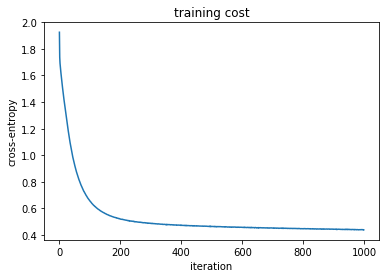

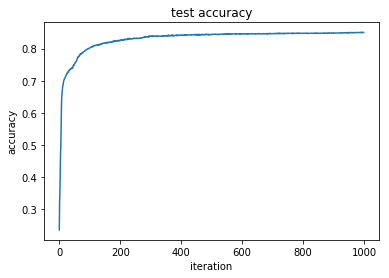

In [20]:
#read train data
trainX, trainY = load_data(train_data_path)

#read test data
testX, testY = load_data(test_data_path)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

#create train and predict function
train, predict = create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output)

# train and test
train_cost, test_accuracy = run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs)

#Plots
%matplotlib inline
draw_plot(range(epochs), train_cost, 'iteration', 'cross-entropy', 'training cost', figure_dir_path, 'pa1_cost.png')
draw_plot(range(epochs), test_accuracy, 'iteration', 'accuracy', 'test accuracy', figure_dir_path, 'pa1_accuracy.png')
